Reproduction of the experiment from Fig 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.stats import norm
import cvxpy as cp

# Quantile Loss

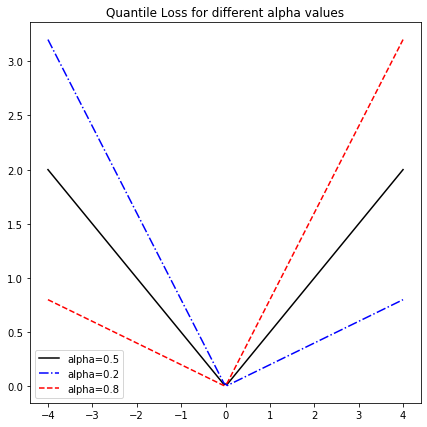

In [2]:
quantile_loss = lambda x, alpha=0.5: x*(alpha - (x<0))

plt.figure(figsize=(7,7))

x = np.linspace(-4,4,100)
plt.plot(x, quantile_loss(x), c="black", label="alpha=0.5")
plt.plot(x, quantile_loss(x,0.2), "b-.", label="alpha=0.2")
plt.plot(x, quantile_loss(x,0.8), "r--", label="alpha=0.8")

plt.title("Quantile Loss for different alpha values")

plt.legend()

plt.show()

In [3]:
x.shape

(100,)

In [4]:
np.maximum(x,2*x)

array([-4.        , -3.91919192, -3.83838384, -3.75757576, -3.67676768,
       -3.5959596 , -3.51515152, -3.43434343, -3.35353535, -3.27272727,
       -3.19191919, -3.11111111, -3.03030303, -2.94949495, -2.86868687,
       -2.78787879, -2.70707071, -2.62626263, -2.54545455, -2.46464646,
       -2.38383838, -2.3030303 , -2.22222222, -2.14141414, -2.06060606,
       -1.97979798, -1.8989899 , -1.81818182, -1.73737374, -1.65656566,
       -1.57575758, -1.49494949, -1.41414141, -1.33333333, -1.25252525,
       -1.17171717, -1.09090909, -1.01010101, -0.92929293, -0.84848485,
       -0.76767677, -0.68686869, -0.60606061, -0.52525253, -0.44444444,
       -0.36363636, -0.28282828, -0.2020202 , -0.12121212, -0.04040404,
        0.08080808,  0.24242424,  0.4040404 ,  0.56565657,  0.72727273,
        0.88888889,  1.05050505,  1.21212121,  1.37373737,  1.53535354,
        1.6969697 ,  1.85858586,  2.02020202,  2.18181818,  2.34343434,
        2.50505051,  2.66666667,  2.82828283,  2.98989899,  3.15

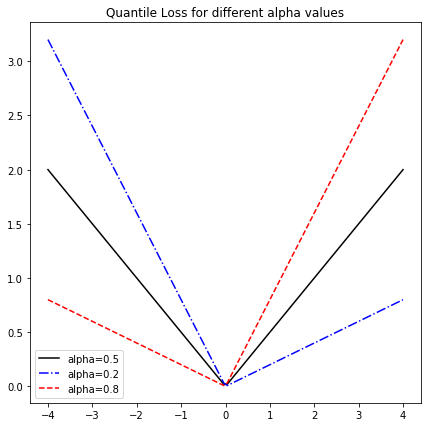

In [5]:
pinball_loss = lambda x, alpha=0.5: np.maximum(alpha*x,(alpha-1)*x)

plt.figure(figsize=(7,7))

x = np.linspace(-4,4,100)
plt.plot(x, pinball_loss(x), c="black", label="alpha=0.5")
plt.plot(x, pinball_loss(x,0.2), "b-.", label="alpha=0.2")
plt.plot(x, pinball_loss(x,0.8), "r--", label="alpha=0.8")

plt.title("Quantile Loss for different alpha values")

plt.legend()

plt.show()

# Generic Data

In [6]:
nsample = 40
sig = np.sqrt(0.25)

X = 2*np.random.random(nsample) - 1
e = sig*np.random.randn(nsample)
y = X + e

theoretical_quantile = lambda x,alpha=0.5,sigma=1: sigma*norm().ppf(alpha) + x

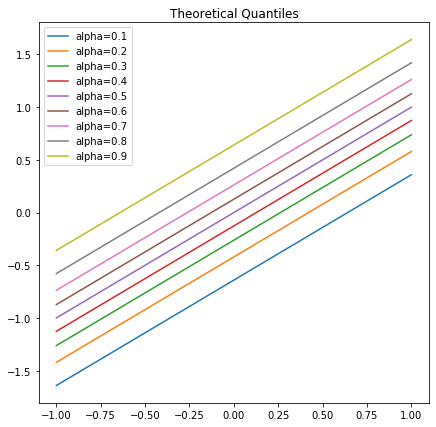

In [7]:
alpha_l = np.arange(0.1,1,0.1)
x = np.linspace(-1,1,100)

plt.figure(figsize=(7,7))

for alpha in alpha_l:
    plt.plot(x, theoretical_quantile(x,alpha,sig), label="alpha={}".format(np.round(alpha,2)))

plt.title("Theoretical Quantiles")
plt.legend()
plt.show()

# Kernel Quantile Regression


The optimal value is 1.5870848787397684

The optimal value is 2.768062861441345

The optimal value is 3.5999637142263947

The optimal value is 4.197684833380538

The optimal value is 4.4836214184747

The optimal value is 3.9124927559414227

The optimal value is 3.2011982357220097

The optimal value is 2.3005708329429906

The optimal value is 1.326691980018228


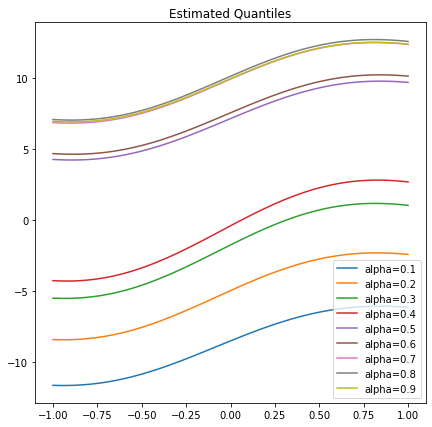

In [8]:
gauss_kernel = lambda x,y,sigma=1: np.exp(-np.sum((x-y)**2)/sigma**2)
quantile_sol = lambda x,w,b: np.sum([w[i]*gauss_kernel(x,X[i]) + b for i in range(nsample)])

sigma=0.1
lambd = 0.05

K = np.zeros((nsample,nsample))
for i in range(nsample):
    for j in range(nsample):
        K[i,j] = gauss_kernel(X[i],X[j],sigma)

alpha_l = np.arange(0.1,1,0.1)

# Generate a random non-trivial quadratic program.
n = 3*nsample + 1 # add intercept
m = 4*nsample

#np.random.seed(1)

P = np.zeros((n,n))
P[0:nsample,0:nsample] = K

G = np.zeros((m,n))
G[0:nsample,nsample:2*nsample] = -np.eye(nsample)
G[nsample:2*nsample,2*nsample:3*nsample] = -np.eye(nsample)
G[2*nsample:3*nsample,0:nsample] = -K
G[2*nsample:3*nsample,nsample:2*nsample] = -np.eye(nsample)
G[3*nsample:4*nsample,0:nsample] = K
G[3*nsample:4*nsample,2*nsample:3*nsample] = -np.eye(nsample)
# add intercept
G[2*nsample:3*nsample,-1] = -1
G[3*nsample:4*nsample,-1] = 1

h = np.zeros(m)
h[2*nsample:3*nsample] = -y
h[3*nsample:4*nsample] = y

abscisse = np.linspace(-1,1,100)
plt.figure(figsize=(7,7))

for alpha in alpha_l:

    q = np.zeros(n)
    q[nsample:2*nsample] = alpha
    q[2*nsample:3*nsample] = 1-alpha

    # Define and solve the CVXPY problem.
    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(lambd*0.5*cp.quad_form(x, P) + q.T @ x),
                     [G @ x <= h])
    prob.solve()

    # Print result.
    #print("\nThe optimal value is", prob.value)
    #print("A solution x is")
    #print(x.value)
    #print("A dual solution corresponding to the inequality constraints is")
    #print(prob.constraints[0].dual_value)
    
    w_opt = x.value[:nsample]
    b = x.value[-1]
    
    t = [quantile_sol(xi,w_opt,b) for xi in abscisse]
    plt.plot(abscisse, t, label="alpha={}".format(np.round(alpha,2)))
    
    
plt.title("Estimated Quantiles")
plt.legend()
plt.show()

Cela a l'air de tres marcher, attention a la dependance sur les hyperparametres cependant. Intercept ???

# Simultaneous Multiple Kernel Quantile Regression

Scaling is really bad with this method, linear dependence in n, dimension of the quadratic problem is: $$\mathcal{O}(pn,pn)$$

Look at complexity of interior point methods. 

In [9]:
# Hyperpatameters
sigma=0.1 # scaling Gaussian Kernel
lambd = 0.001 # regularisation strength
alpha_l = np.arange(0.1,1,0.1) # list of quantiles to estimate
p = len(alpha_l) # number of simultaneously estimated quantiles

# Feed Gaussian Kernel
K = np.zeros((nsample,nsample))
for i in range(nsample):
    for j in range(nsample):
        K[i,j] = gauss_kernel(X[i],X[j],sigma)

In [10]:
# np.random.seed(1)

# QP Dimension
n = 3*p*nsample 
m = (p-1)*nsample + 4*p*nsample

############## Variables to solve QP ##########################
P = np.zeros((n,n))
for k in range(p):
    P[k*nsample:(k+1)*nsample,k*nsample:(k+1)*nsample] = K

#for k in range(p):
    #q[p+2*k*nsample:p+(2*k+1)*nsample] = alpha
    #q[p+(2*k+1)*nsample:p+2*(k+1)*nsample] = 1-alpha
q = np.zeros(n)
for k in range(p):
    q[p*nsample+k*nsample:p*nsample+(k+1)*nsample] = alpha_l[k]
    q[2*p*nsample+k*nsample:2*p*nsample + (k+1)*nsample] = 1-alpha_l[k]
    
h = np.zeros(m)
h[(p-1)*nsample + 2*p*nsample:(p-1)*nsample + 3*p*nsample] = -np.tile(y,p)
h[(p-1)*nsample + 3*p*nsample:(p-1)*nsample + 4*p*nsample] = np.tile(y,p)

nbis = nsample*(p-1)
mbis = nsample*p
G1 = np.zeros((nbis,mbis))
for i in range(nbis):
    G1[i,i] = 1
for i in range(nbis):
    G1[i,i+nsample] = -1   
G2 = -np.eye(mbis)
G12 = block_diag(G1,G2,G2)
G3 = np.hstack([block_diag(*([-K]*p)),-np.eye(mbis),np.zeros((mbis,mbis))])
G4 = np.hstack([block_diag(*([K]*p)),np.zeros((mbis,mbis)),np.eye(mbis)])
G = np.vstack([G12,G3,G4])
##############################################################

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(lambd*0.5*cp.quad_form(x, P) + q.T @ x),[G @ x <= h])
prob.solve()
print("\nThe optimal value is", prob.value)


The optimal value is -inf


In [11]:
# Get Optimal weights:
w_opt = x.value.copy()

AttributeError: 'NoneType' object has no attribute 'copy'

In [ ]:
print(w_opt.shape)

In [ ]:
# Plot results 
abscisse = np.linspace(-1,1,100)
plt.figure(figsize=(7,7))

for k in range(p):
    print(k)
    print(k*nsample,(k+1)*nsample)
    w = w_opt[k*nsample:(k+1)*nsample]
    print(w)
    t = [quantile_sol(xi,w) for xi in abscisse]
    plt.plot(abscisse, t, label="alpha={}".format(np.round(alpha_l[k],2)))
    
plt.title("Estimated Quantiles (multi-task)")
plt.legend()
plt.show()

In [ ]:
a = [[1,2],[3,4]]
b = [[5,6],[7,8]]
print(block_diag(a,b))

n=3
m=3
nbis = n*(m-1)
mbis = n*m
G1 = np.zeros((n*(m-1),n*m))
for i in range(nbis):
    G1[i,i] = 1
for i in range(nbis):
    G1[i,i+n] = -1
    
print(G1)
print(G1.shape)

G2 = -np.eye(mbis)
print(G2)

G12 = block_diag(G1,G2,G2)
print(G12.shape)

K = np.arange(9).reshape(3,3)
G3 = np.hstack([block_diag(*([-K]*3)),-np.eye(mbis),np.zeros((mbis,mbis))])
G3.shape

G4 = np.hstack([block_diag(*([K]*3)),np.zeros((mbis,mbis)),np.eye(mbis)])

G = np.vstack([G12,G3,G4])
print(G.shape)


print("Final Shape",(3-1)*3 + 4*3*3, 3*3*3)